<a href="https://colab.research.google.com/github/Louis5228/2020-Machine-Learning/blob/main/hw3_309512014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import cv2
from numpy.linalg import inv, pinv, linalg
from PIL import Image
from scipy.stats import multivariate_normal
import prettytable as pt
from sklearn.svm import SVC
from collections import Counter
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Machine_Learning/HW3/dataset")

# 1. Gaussian Process for Regression

In [ ]:
x_data = pd.read_csv("gp_x.csv", header=None)
t_data = pd.read_csv("gp_t.csv", header=None)

x_data = np.array(x_data)
t_data = np.array(t_data)

In [ ]:
Num = 50
x_train = x_data[:Num]
t_train = t_data[:Num]
x_test = x_data[Num:]
t_test = t_data[Num:]

theta_config = [[0,  0,  0, 1],
                [1, 16,  0, 0],
                [1, 16,  0, 4],
                [1, 64, 32, 0],
                [8, 256, 0, 0]] # trial and error config
beta_inv = 1

In [ ]:
def cal_ker(theta, xn, xm):
  return theta[0] * math.exp(-theta[1]*0.5 * (xn - xm)**2) + theta[2] + theta[3] * xn * xm

def cal_Gaussian(thera, xn, cov_inv):
  k = np.zeros((Num,1))
  for i in range(Num):
    k[i,0] = cal_ker(theta, x_train[i], xn)
  c = cal_ker(theta, xn, xn) + beta_inv
  mean = (k.T).dot(cov_inv).dot(t_train)
  var = c - (k.T).dot(cov_inv).dot(k)
  return mean, var

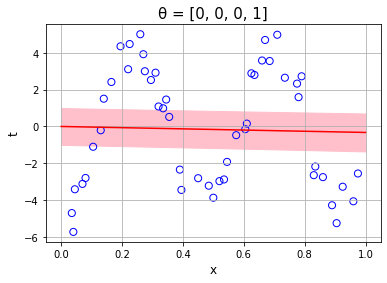

RMS error of training data : 3.1292014298222433
RMS error of testing  data : 3.3443986601861146
--------------------------------------------------


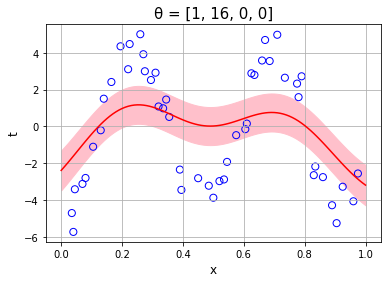

RMS error of training data : 2.4239279278312194
RMS error of testing  data : 2.6680517502524466
--------------------------------------------------


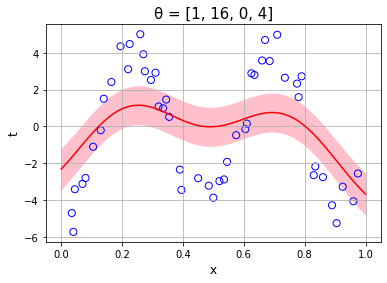

RMS error of training data : 2.410576487125207
RMS error of testing  data : 2.6569980001669165
--------------------------------------------------


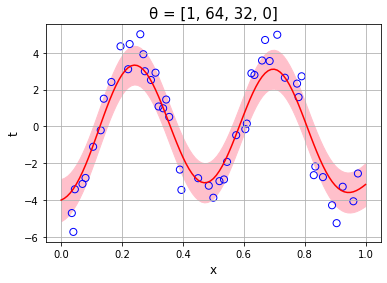

RMS error of training data : 1.0428861621832217
RMS error of testing  data : 1.1627590936118453
--------------------------------------------------


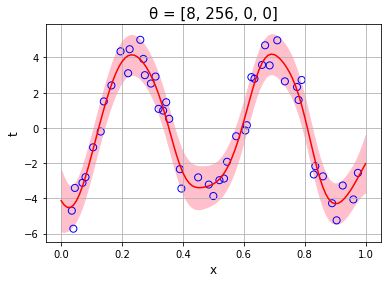

RMS error of training data : 0.6727647429593011
RMS error of testing  data : 1.0411559204230687
--------------------------------------------------


In [ ]:
x = np.arange(0, 1.01, 0.01)

for theta in theta_config:
  y = np.zeros(0)
  std = np.zeros(0)
  cov = np.zeros((Num, Num))
  for i in range(Num):
    for j in range(Num):
      cov[i,j] = cal_ker(theta, x_train[i], x_train[j])
      if i == j:
        cov[i,j] += beta_inv
  cov_inv = inv(cov)

  for xn in x:
    mean, var = cal_Gaussian(theta, xn, cov_inv)
    y = np.append(y, mean)
    std = np.append(std, math.sqrt(var))
  
  RMS_err_train = 0
  for i in range(Num):
    mean, var = cal_Gaussian(theta, x_train[i], cov_inv)
    RMS_err_train += (mean - t_train[i])**2
  RMS_err_train = math.sqrt(RMS_err_train / Num)

  RMS_err_test = 0
  for i in range(x_data.shape[0] - Num):
    mean, var = cal_Gaussian(theta, x_test[i], cov_inv)
    RMS_err_test += (mean - t_test[i])**2
  RMS_err_test = math.sqrt(RMS_err_test / (x_data.shape[0] - Num))

  plt.plot(x, y, c='r')    
  plt.fill_between(x, y - std, y + std, color='pink')
  plt.scatter(x_train, t_train, s=50, facecolors='none', edgecolors='b')
  plt.title("θ = " + str(theta), fontsize = 15)
  plt.xlabel("x", fontsize = 12)
  plt.ylabel("t", fontsize = 12)
  plt.grid(True)
  plt.show()
  print("RMS error of training data : " + str(RMS_err_train))
  print("RMS error of testing  data : " + str(RMS_err_test))
  print("-"*50)

# 2. Support Vector Machine ( SVM )

In [2]:
x_data = pd.read_csv("x_train.csv", header=None)
t_data = pd.read_csv("t_train.csv", header=None)

x_data = np.array(x_data)
t_data = np.array(t_data)

In [3]:
def PCA(d, data):
  new_data = data - np.mean(data, axis=0)
  U, Sigma, Vh = np.linalg.svd(new_data.T)
  pca_data = np.dot(new_data, U[:,:d])
  return pca_data

In [4]:
pca_x = PCA(2, x_data)
x_train = (pca_x - np.mean(pca_x)) / np.std(pca_x) # Normalize
t_train = t_data

In [102]:
def cal_phi_x(x, _type):
  if _type == 'Linear':
    phi_x = x
  else:
    if len(x.shape) == 1:
      x = x.reshape(1,2)
    phi_x = np.vstack((x[:,0]**2, np.sqrt(2)*x[:,0]*x[:,1], x[:,1]**2)).T
  return phi_x

def kernel_func(xi, xj):
  return np.dot(cal_phi_x(xi, _type), cal_phi_x(xj, _type).T)

In [100]:
def fit(x, t):
  if _type == 'Linear':
    clf = SVC(kernel='linear', C=C)
  else:
    clf = SVC(kernel='poly', C=C, degree=2)
  clf.fit(x, t)
  coef = np.abs(clf.dual_coef_) 
  sv_indx = clf.support_ 
  return coef, sv_indx

def get_para(x):
  # target 
  targ_dict = {}
  targ_dict[class_label[0]] = np.concatenate((np.ones(100), np.full([100], -1), np.zeros(100)))
  targ_dict[class_label[1]] = np.concatenate((np.ones(100), np.zeros(100), np.full([100], -1)))
  targ_dict[class_label[2]] = np.concatenate((np.zeros(100), np.ones(100), np.full([100], -1)))
  
  # multiplier
  multi = np.zeros((x.shape[0], 2))
  multi[sv_indx] = coef.T

  multi_dict = {}
  multi_dict[class_label[0]] = np.concatenate((multi[:200, 0], np.zeros(100)))
  multi_dict[class_label[1]] = np.concatenate((multi[:100, 1], np.zeros(100), multi[200:, 0]))
  multi_dict[class_label[2]] = np.concatenate((np.zeros(100), multi[100:, 1]))
  return targ_dict, multi_dict

# Get weight & Bias
def get_w_b(alpha, t, x):
  phi_x = cal_phi_x(x, _type)
  w = np.dot((alpha * t), phi_x)
  M_indx = np.where(((alpha > 0) & (alpha < C)))[0]
  S_indx = np.nonzero(alpha)[0]
  if len(M_indx) == 0:
    bias = 0
  else:
    kernal = kernel_func(x[M_indx], x[S_indx])
    bias = np.mean(t[M_indx] - np.dot((alpha * t)[S_indx], kernal.T))

  return w, bias

def train(x, t):
  target_dict, multiplier_dict = get_para(x)
  for i in class_label:
    alpha = multiplier_dict[i]
    target = target_dict[i]
    weight, bias = get_w_b(alpha, target, x)
    weight_dict[i] = weight
    bias_dict[i] = bias

  return weight_dict, bias_dict

def meshgrid(x, y, h=2e-2):
  space = 0.3
  x_min = x.min() - space
  x_max = x.max() + space
  y_min = y.min() - space
  y_max = y.max() + space
  mesh_x, mesh_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  return mesh_x, mesh_y

def predict(x):
  predict = []
  for indx in range(x.shape[0]):
    votes = []
    for i in class_label:
      phi_x = cal_phi_x(x[indx], _type)
      w = weight_dict[i]
      bias = bias_dict[i]
      y = np.dot(w, phi_x.T) + bias
      if y > 0:
        votes.append(i[0])
      else:
        votes.append(i[1])
    predict.append(Counter(votes).most_common()[0][0])
  return predict

In [10]:
def plot_img(x, t, xx, yy, prediction):
  c0_indx = np.where(t == 0)[0]
  c1_indx = np.where(t == 1)[0]
  c2_indx = np.where(t == 2)[0]
  plt.title(_type, fontsize = 15)
  plt.scatter(x[sv_indx, 0], x[sv_indx, 1], s=50, facecolors='none', edgecolors='k', linewidths=1.5, label="Support Vector")
  plt.scatter(x[c0_indx][:, 0], x[c0_indx][:, 1], c='b', marker='x', label="Tibetan 0")
  plt.scatter(x[c1_indx][:, 0], x[c1_indx][:, 1], c='r', marker='x', label="Tibetan 1")
  plt.scatter(x[c2_indx][:, 0], x[c2_indx][:, 1], c='g', marker='x', label="Tibetan 2")
  plt.contourf(xx, yy, prediction, alpha=0.2, cmap=plt.cm.brg)
  plt.legend()
  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


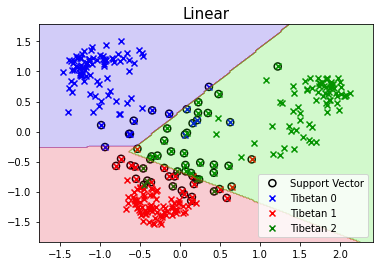

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


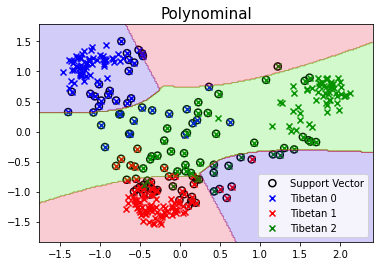

In [101]:
class_l = ['Linear', 'Polynominal']
C = 1
class_label = [(0, 1), (0, 2), (1, 2)]
for c in class_l:
  _type = c
  weight_dict = {}
  bias_dict = {}
  coef, sv_indx = fit(x_train, t_train)
  weight_dict, bias_dict = train(x_train, t_train)
  xx, yy = meshgrid(x_train[:, 0], x_train[:, 1])
  prediction = predict(np.column_stack((xx.flatten(), yy.flatten())))
  plot_img(x_train, t_train, xx, yy, np.array(prediction).reshape(xx.shape))

# 3. Gaussian Mixture Model

In [ ]:
img = Image.open('imghw3.jpg')
img.load()
img = np.asarray(img, dtype='float')
height, width, depth = img.shape

data = img.reshape((-1, depth)) / 255.0 #(76480, 3)

In [ ]:
dot_num = img.shape[0]*img.shape[1]
# 初始元素
x = data[:,0]  # r
y = data[:,1]  # g
z = data[:,2]  # b

# 兩點之間的距離
def dis(x, y, z, kx, ky, kz):
    return ((kx-x)**2 + (ky-y)**2 + (kz-z)**2)**0.5

# 對每筆元素進行分群
def cluster(x, y, z, kx, ky, kz):
  team = []
  rnk = np.zeros([dot_num, seed_num])
  for i in range(seed_num):
    team.append([])
  mid_dis = 99999999
  for i in range(dot_num):
    for j in range(seed_num):
      distant = dis(x[i], y[i], z[i], kx[j], ky[j], kz[j])
      if distant < mid_dis:
        mid_dis = distant
        flag = j
    team[flag].append([x[i], y[i], z[i]])
    rnk[i, flag] = 1.0
    mid_dis = 99999999
  return team, rnk

# 對分群完的元素找出新的群集中心
def re_seed(team, kx, ky, kz):
  sumx = 0
  sumy = 0
  sumz = 0
  new_seed = []
  for index, nodes in enumerate(team):
    if nodes == []:
      new_seed.append([kx[index], ky[index], kz[index]])
    else:
      for node in nodes:
        sumx += node[0]
        sumy += node[1]
        sumz += node[2]
      new_seed.append([sumx/len(nodes), sumy/len(nodes), sumz/len(nodes)])
    sumx = 0
    sumy = 0
    sumz = 0
  nkx = []
  nky = []
  nkz = []
  for i in new_seed:
    nkx.append(i[0])
    nky.append(i[1])
    nkz.append(i[2])
  return nkx, nky, nkz

In [ ]:
def GMM(data, K, k_means_mu, k_means_rnk, max_iteration=100):
  # Initialize
  pi = np.sum(k_means_rnk, axis=0) / len(k_means_rnk)
  cov = np.array([ np.cov(data[np.where(k_means_rnk[:, k] == 1)[0]].T) for k in range(K) ])
  gauss = np.array([ multivariate_normal.pdf(data, mean=k_means_mu[k], cov=cov[k])*pi[k] for k in range(K) ])
  likelihood = []
  # Expectation Maximization (EM)
  for it in range(max_iteration):
    gamma = (gauss / np.sum(gauss, axis=0)).T
    Nk = np.sum(gamma, axis=0) 
    mu = np.sum(gamma[:, :, None]*data[:, None], axis=0) / Nk[:, None]
    for k in range(K):
      cov[k] = (gamma[:, k, None]*(data - mu[k])).T.dot(data - mu[k]) / Nk[k] + 1e-7 * np.eye(depth)
    pi = Nk / len(data)
    # Evaulate
    for k in range(K):
      try:
        gauss[k] = multivariate_normal.pdf(data, mean=mu[k], cov=cov[k])*pi[k] 
      except np.linalg.linalg.LinAlgError:
        print('Sngular error at iteration %d' % it)
        mu[k] = np.random.rand(depth)
        temp = np.random.rand(depth, depth)
        cov[k] = temp.dot(temp.T)
        gauss[k] = multivariate_normal.pdf(data, mean=mu[k], cov=cov[k])*pi[k]   
    likelihood.append(np.sum(np.log(np.sum(gauss, axis=0))))
  return mu, gauss, likelihood

In [ ]:
def plot_original_img():
  plt.title('Original Image', fontsize = 15), plt.xticks([]), plt.yticks([])
  plt.imshow(img.astype(int))
  plt.show()

In [ ]:
def plot_log(likelihood_records):
  plt.title('Log likelihood of GMM (k=%d)' % k, fontsize = 15)
  plt.xlabel("Iterations", fontsize = 12)
  plt.ylabel("Log likelihood", fontsize = 12)
  plt.plot(np.arange(100), likelihood_records)
  plt.show()

  # Save image to Google Drive
  # plt.savefig('/content/gdrive/My Drive/Machine_Learning/HW3/log_likelihood_'+str(k)+'.png')

In [ ]:
def print_table(K, mu, _type):
  mu = mu * 255
  print('-'*50)
  print("============== K = %d (%s) ==============" % (K, _type))
  print("%-8s:      R           G           B" % (_type))
  for k in range(K):
    print("%-8d:  %10f  %10f  %10f" % (k, mu[k,0], mu[k,1], mu[k,2]))

In [ ]:
def plot_img(mu, rnk, gaussians, _type):
  if _type == 'K_means':
      new_img = (mu[np.where(rnk == 1)[1]]*255).astype(int)
  else:
      new_img = (mu[np.argmax(gaussians, axis=0)]*255).astype(int)

  show_img = new_img.reshape((height, width, depth))
  plt.title('K = '+str(k)+' ('+str(_type)+')', fontsize = 15), plt.xticks([]), plt.yticks([])
  plt.imshow(show_img)
  plt.show()

  # Save image to Google Drive
  # disp = Image.fromarray(new_img.reshape(height, width, depth).astype('uint8'))
  # disp.save('/content/gdrive/My Drive/Machine_Learning/HW3/'+_type+str(k)+'.png')

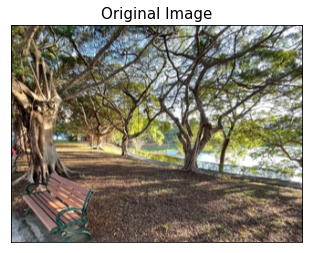

--------------------------------------------------
============== K = 3 (K_means) ==============
K_means :      R           G           B
0         133.067653  126.076268  104.318174
1          73.971638   66.620424   52.861013
2         194.108578  195.774972  182.425473


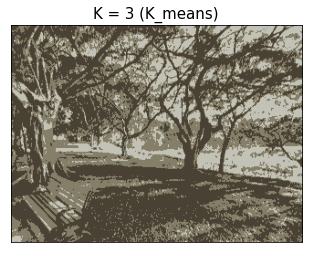

--------------------------------------------------
============== K = 3 (GMM) ==============
GMM     :      R           G           B
0         137.086473  125.350120   87.284798
1          80.297613   67.365818   58.843954
2         128.226785  131.853193  124.523494


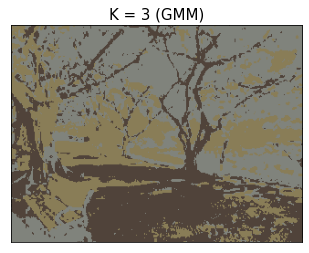

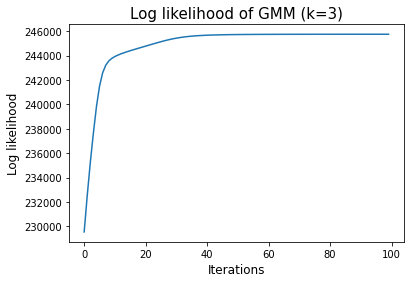

In [ ]:
# K_l = [3, 5, 7, 10]
K_l = [3]

plot_original_img()
for k in K_l:
  # 群集中心和元素的數量
  seed_num = k
  
  # 初始群集中心
  kx = np.random.randint(0, 256, seed_num) / 255.0
  ky = np.random.randint(0, 256, seed_num) / 255.0
  kz = np.random.randint(0, 256, seed_num) / 255.0

  # K_means
  while(True):
    team, rnk = cluster(x, y, z, kx, ky, kz)
    nkx, nky, nkz = re_seed(team, kx, ky, kz)
    if nkx == list(kx) and nky == list(ky) and nkz == list(kz):
      k_means_mu = np.column_stack((np.array(nkx), np.array(nky), np.array(nkz)))
      k_means_rnk = rnk
      break
    else:
      kx, ky, kz = nkx, nky, nkz

  print_table(k, k_means_mu, 'K_means')
  plot_img(k_means_mu, k_means_rnk, None, 'K_means')

  gmm_mu, gmm_gauss, gmm_likelihood_records = GMM(data, k, k_means_mu, k_means_rnk)
  
  print_table(k, gmm_mu, 'GMM')
  plot_img(gmm_mu, None, gmm_gauss, 'GMM')
  plot_log(gmm_likelihood_records)

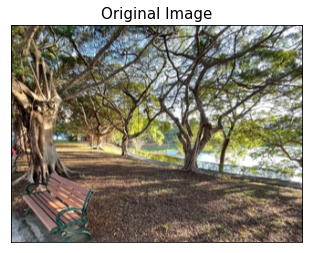

--------------------------------------------------
======= K = 3 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 194 | 195 | 182 |
|    1    | 133 | 126 | 104 |
|    2    |  73 |  66 |  52 |
+---------+-----+-----+-----+


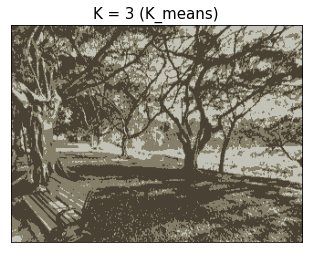

--------------------------------------------------
======= K = 3 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 128 | 131 | 124 |
|  1  | 137 | 125 |  87 |
|  2  |  80 |  67 |  58 |
+-----+-----+-----+-----+


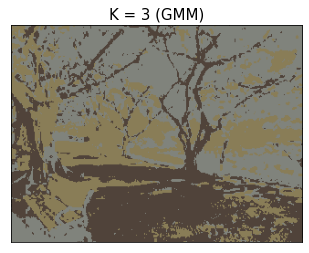

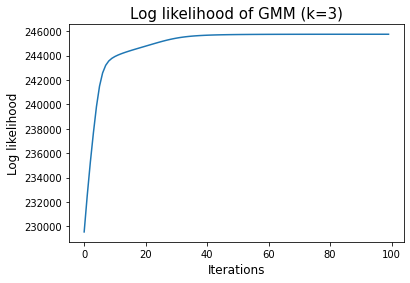

--------------------------------------------------
======= K = 5 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 133 | 125 | 103 |
|    1    | 169 | 168 | 148 |
|    2    | 214 | 217 | 210 |
|    3    |  93 |  86 |  69 |
|    4    |  59 |  52 |  39 |
+---------+-----+-----+-----+


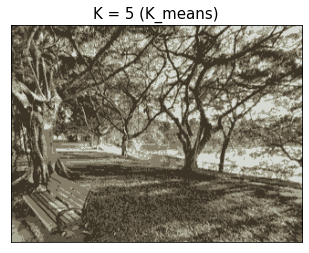

--------------------------------------------------
======= K = 5 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 126 | 111 |  85 |
|  1  | 142 | 151 | 112 |
|  2  | 160 | 166 | 165 |
|  3  |  74 |  71 |  60 |
|  4  |  79 |  65 |  58 |
+-----+-----+-----+-----+


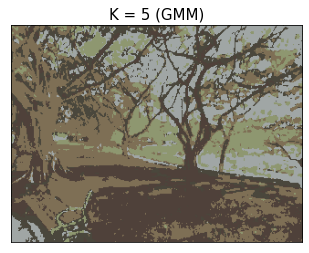

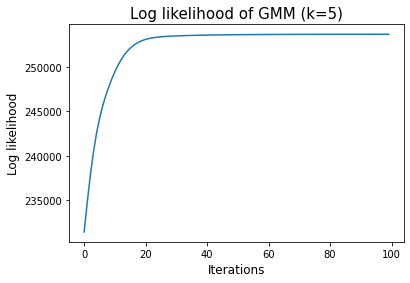

--------------------------------------------------
======= K = 7 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 115 | 107 |  87 |
|    1    |  53 |  46 |  34 |
|    2    | 159 | 144 | 103 |
|    3    | 133 | 141 | 141 |
|    4    |  82 |  75 |  61 |
|    5    | 222 | 225 | 221 |
|    6    | 183 | 183 | 166 |
+---------+-----+-----+-----+


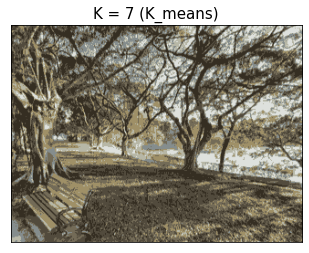

--------------------------------------------------
======= K = 7 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 125 | 108 |  85 |
|  1  |  78 |  65 |  58 |
|  2  | 127 | 131 |  73 |
|  3  | 141 | 147 | 147 |
|  4  |  69 |  65 |  52 |
|  5  | 227 | 228 | 228 |
|  6  | 156 | 164 | 146 |
+-----+-----+-----+-----+


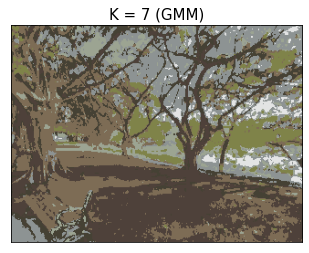

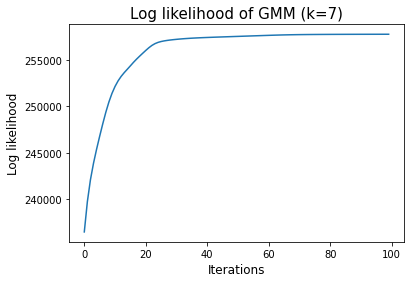

--------------------------------------------------
======= K = 10 (K_means) =======
+---------+-----+-----+-----+
| K_means |  R  |  G  |  B  |
+---------+-----+-----+-----+
|    0    | 188 | 195 | 192 |
|    1    | 231 | 233 | 229 |
|    2    |  44 |  38 |  25 |
|    3    | 199 | 184 | 130 |
|    4    | 151 | 159 | 157 |
|    5    | 119 | 108 |  82 |
|    6    |  70 |  62 |  49 |
|    7    | 118 | 124 | 122 |
|    8    | 155 | 139 | 103 |
|    9    |  90 |  84 |  69 |
+---------+-----+-----+-----+


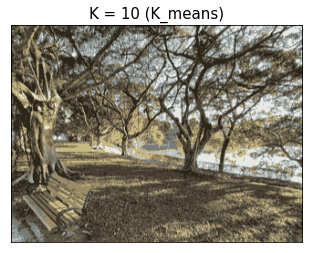

--------------------------------------------------
======= K = 10 (GMM) =======
+-----+-----+-----+-----+
| GMM |  R  |  G  |  B  |
+-----+-----+-----+-----+
|  0  | 173 | 179 | 170 |
|  1  | 227 | 228 | 228 |
|  2  |  62 |  55 |  35 |
|  3  | 126 | 130 |  71 |
|  4  | 150 | 153 | 151 |
|  5  | 126 | 107 |  84 |
|  6  |  78 |  65 |  58 |
|  7  | 116 | 122 | 126 |
|  8  | 161 | 147 | 116 |
|  9  |  88 |  85 |  73 |
+-----+-----+-----+-----+


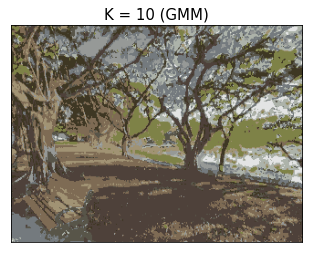

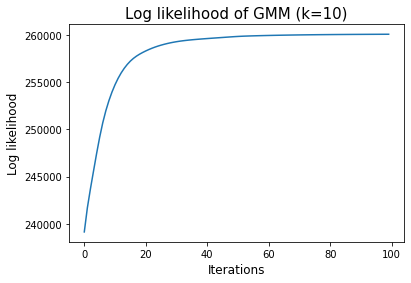

In [ ]:
K_l = [3, 5, 7, 10]

plot_original_img()
for k in K_l:
  k_means_mu, k_means_rnk = K_means(data, k)

  print_table(k, k_means_mu, 'K_means')
  plot_img(k_means_mu, k_means_rnk, None, 'K_means')

  gmm_mu, gmm_gauss, gmm_likelihood_records = GMM(data, k, k_means_mu, k_means_rnk)
  
  print_table(k, gmm_mu, 'GMM')
  plot_img(gmm_mu, None, gmm_gauss, 'GMM')
  plot_log(gmm_likelihood_records)